# Inversion of a Transect of MT Tipper data. Part I

This dataset consists of 29 Magnetotelluric stations arranged on a 2D transect. Our objective is to invert the tipper data on line 5000 using MtPy to (hopefully) reveal a conductive structure known to exist under the array. While the task is straightforward, there are a number of smaller tasks we'll have to complete in sequence:

1) Loading and cleaning the data

2) Parsing data into MtPy compatible formats

3) Visualizing the data

4) Set up Occam2D Inversion

5) Explore Inversion Parameters

6) Analyze Results

Before following this jupyter notebook tutorial, ensure you have the latest version of miniconda3 installed. Create an ```mtpy_inversion``` environment by installing the following packages in series
```
conda create --name mtpy_inversion
source activate mtpy_inversion
conda install python=3.6.8
conda install numpy scipy matplotlib pandas cartopy
pip install mtpy
```

#### How to use this notebook

Cells in this notebook are divided into two types:

- Helper Cells

- Data Manipulation/Exploration Cells

Only the "Helper cells" are labeled for convenience. You may, of course, edit any cell you wish, or copy bits of code to use in your own analysis. There is one external module you need called ```cartopy_mapping.py```. Make sure this python file is in the same directory you run this notebook from.

This notebook performs steps 1) and 2) as described above. It is meant to be used prior to executing Part_2.Data_Analysis. The first cell you execute will shoot out some warnings. Don't worry, this won't affect anything.

After you're done with this notebook move on to Part II.

## Step 1. load the data. 

The data are provided in a .csv file. Since pandas is well-suited for loading csv's, I'll load it into a pandas dataframe.

In [1]:
"""
HELPER CELL

for importing relevant modules

"""

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage as nd
import cartopy_mapping
import numpy as np
from mtpy.core.z import Tipper, Z
from mtpy.core.mt import MT
import os
import glob

GDAL_DATA environment variable is not set  Please see https://trac.osgeo.org/gdal/wiki/FAQInstallationAndBuilding#HowtosetGDAL_DATAvariable 


Ignore GDAL as it is not working. Will use pyproj
Ignore GDAL as it is not working. Will use pyproj
Ignore GDAL as it is not working. Will use pyproj


In [2]:
data = pd.read_csv('original_data/YGS-20200107-ELF_with_repeat_readings.csv')

Let's Look at the data dimensions

In [3]:
data

,Line,Station,Lat,Long,E_WGS84_Z7,N_WGS84_Z7,ALT,Az,Dur,Noise,...,iN_0720,iN_1440,SNI_0011,SNI_0022,SNI_0045,SNI_0090,SNI_0180,SNI_0360,SNI_0720,SNI_1440
0,0,0,61.362678,-139.262820,592876.0,6804421.0,1271.7,9.4,164,0.0,...,0.070,0.159,27.3,132.4,330.9,606.8,759.6,765.9,243.9,72.5
1,0,0,61.362678,-139.262820,592876.0,6804421.0,1271.7,79.9,226,0.0,...,0.038,0.048,48.5,65.3,510.1,1254.6,2970.4,5078.0,5034.9,2071.3
2,0,250,61.364319,-139.259848,593030.0,6804608.0,1257.7,130.6,251,0.0,...,-0.007,-0.003,30.8,152.1,389.2,713.9,812.3,913.9,399.7,110.1
3,0,500,61.365838,-139.256965,593179.6,6804781.3,1268.5,145.8,180,0.0,...,0.014,0.050,68.4,123.8,288.8,544.9,650.4,477.9,197.1,16.0
4,0,750,61.367767,-139.253557,593356.0,6805001.0,1233.2,238.9,160,0.0,...,0.031,0.026,36.1,122.3,370.8,770.2,1274.0,1790.1,1565.3,498.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,11000,6250,61.339016,-139.031672,605311.0,6802137.0,846.5,349.9,188,0.0,...,0.001,-0.030,28.4,152.8,437.3,800.6,512.8,412.7,127.9,20.5
418,11000,6500,61.340766,-139.028496,605475.0,6802337.0,838.2,253.4,164,0.0,...,0.014,-0.022,108.3,126.6,325.2,675.6,864.5,913.2,468.9,105.8
419,11000,6750,61.342338,-139.025425,605634.0,6802517.0,833.4,286.7,165,0.1,...,0.034,-0.067,149.3,212.9,578.6,963.7,763.2,506.8,110.0,11.0
420,11000,7000,61.343953,-139.022219,605800.0,6802702.0,827.6,199.1,197,0.1,...,-0.011,NaN,137.9,221.2,555.7,948.2,893.5,293.1,64.3,4.6


I know the .csv data is structured Like so:

* **Line**: Local grid's line value
* **Station**: Local grid's station value
* **Lat**: Latitude
* **Longitude**: Longitude
* **E_WGS84_Z7**: Easting
* **N_WGS84_Z7z**: Northing
* **ALT**: Station Altitude (m)
* **DUR**: Duration of the reading (s)
* **Noise**: Level of Industrial Noise
* **nE_M**: East Tipper measurement of frequency M. if ```n=='r'```, data is the real component. If ```n=='i'```, data is the imaginary component.
* **nN_M**: North Tipper measurement of frequency M. if ```n=='r'```, data is the real component. If ```n=='i'```, data is the imaginary component.
* **SNI_M**: Signal-to-noise index of component M.

**M** takes on the values of 11, 22, 45, 90, 180, 360, 720, and 1440 Hz.

I will further assume the tipper is defined as:

$$H_z(\omega) = \bf{[}T_n(\omega), T_e(\omega)\bf{]}\begin{bmatrix}
           H_n(\omega) \\
           H_e(\omega) \\
         \end{bmatrix}$$
         
And individual components can be expressed as
$$\frac{H_z(\omega)}{H_n(\omega)} = T_n(\omega)$$


$$\frac{H_z(\omega)}{H_e(\omega)} = T_e(\omega)$$

It appears as if each row represents the $T_x(\omega)$ data and metadata relevant to a single station. Lets check how many stations exist in line 5000.

In [4]:
data_line_5000=data[data['Line']==5000]
len(data_line_5000.Station.unique())

29

How many repeat measurements can we find in this line?

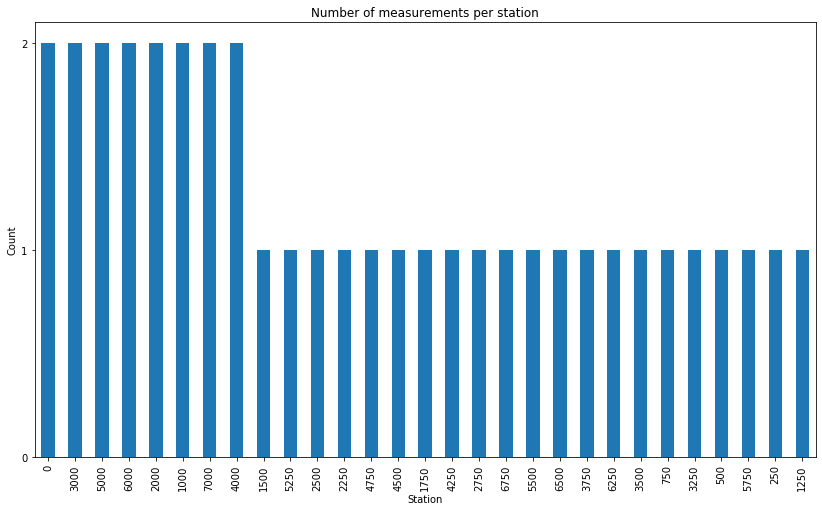

In [5]:
ax = data_line_5000['Station'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of measurements per station")
ax.set_xlabel("Station")
ax.set_ylabel("Count")
ax.set_yticks([0,1,2])

Stations 0, 3000,5000,6000,2000,1000,7000, and 4000 have 2 repeat occupations. All the other lines appear to only have one occupation. For now lets drop the first ocurrence of each repeat occupation.

In [6]:
df_1            = data_line_5000.sort_values(by=['Station'],ascending = [True])
df_1['cumcount']= df_1.groupby('Station').cumcount()
data_line_5000  = data_line_5000[df_1['cumcount'] ==0]
data_line_5000  = data_line_5000.sort_values(by=['Station'],ascending = [True])

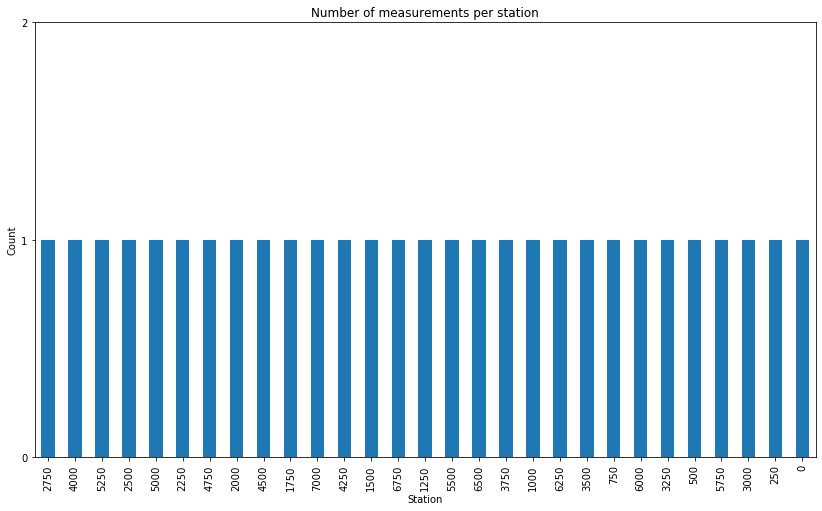

In [7]:
ax = data_line_5000['Station'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of measurements per station")
ax.set_xlabel("Station")
ax.set_ylabel("Count")
ax.set_yticks([0,1,2])

I'm not sure why the stations aren't sorted in ascending order, but our station-pruning operation has been successful.


While we have the metadata nicely packed away in a dataframe, lets see how the stations are distributed

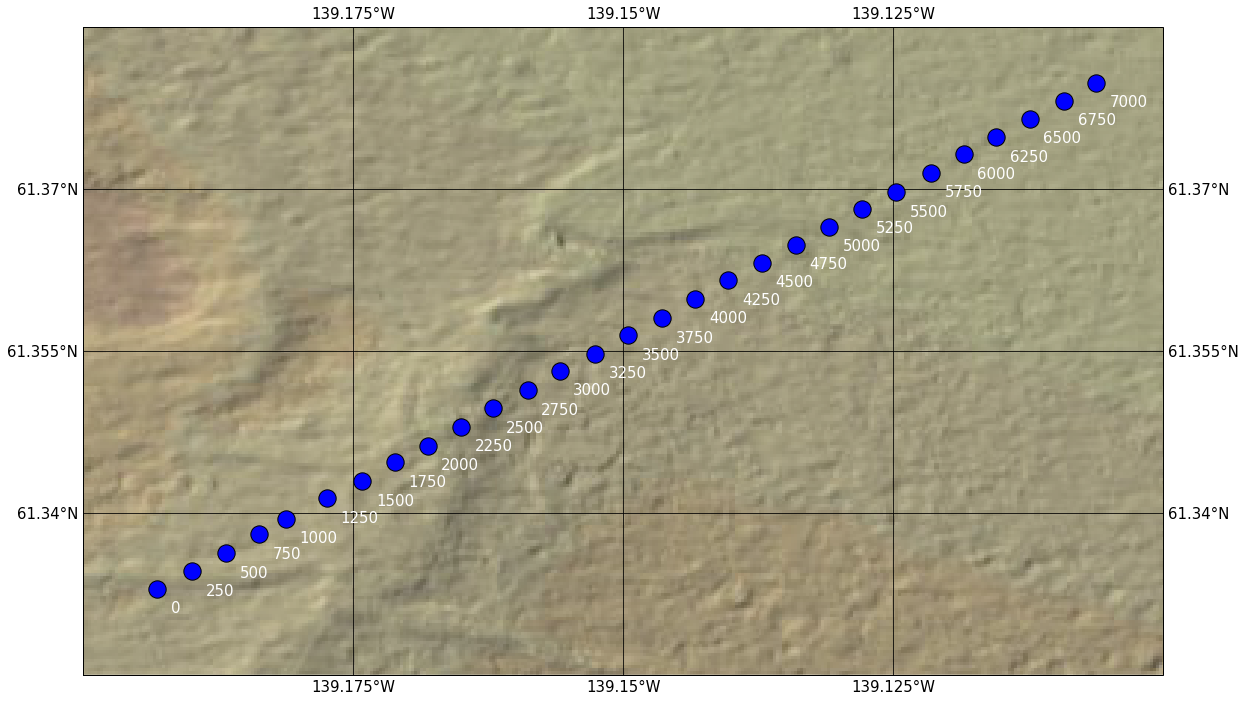

In [8]:
cartopy_mapping.plot_map(data_line_5000)

The data are arranged on a nice NE-SW transect. How about the data itself?

In [9]:
"""
HELPER CELL

for plotting the data, separating by both direction and real/imaginary component.

"""
def sort_data_into_columns(df,direction='N',part='real'):
    data_columns = ['rE_0011', 'rE_0022', 'rE_0045', 'rE_0090',
       'rE_0180', 'rE_0360', 'rE_0720', 'rE_1440', 'rN_0011', 'rN_0022',
       'rN_0045', 'rN_0090', 'rN_0180', 'rN_0360', 'rN_0720', 'rN_1440','iE_0011', 'iE_0022', 'iE_0045', 'iE_0090', 'iE_0180', 'iE_0360',
       'iE_0720', 'iE_1440', 'iN_0011', 'iN_0022', 'iN_0045', 'iN_0090',
       'iN_0180', 'iN_0360', 'iN_0720', 'iN_1440']
    cols_to_use =[]
    for col in data_columns:
        if direction in col:
            if part=='real':
                if 'r' in col:
                    cols_to_use.append(col)
            else:
                if 'i' in col:
                    cols_to_use.append(col)
                    
    d_subset = df.loc[:,cols_to_use]
    d_subset = d_subset.reindex(sorted(d_subset.columns), axis=1)
    return d_subset

def plot_data(df,direction='N',part='real'):
    d_subset     = sort_data_into_columns(df,direction=direction,part=part)
    frequencies  = [int(x.split('_')[1]) for x in d_subset.columns]
    stations     = df['Station'].values
    data         = d_subset.values

    fig,ax = plt.subplots(figsize=(10,10))
    current_cmap = cm.get_cmap()
    current_cmap.set_bad(color='red')
    im = ax.imshow(data.T)
    cbar = ax.figure.colorbar(im, ax=ax,fraction=0.012, pad=0.04)
    cbar.ax.set_ylabel('value', rotation=-90, va="bottom")
    ax.set_xticks(np.arange(len(stations)))
    ax.set_yticks(np.arange(len(frequencies)))
    ax.set_xticklabels(stations)
    ax.set_yticklabels(frequencies)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    ax.set_title("{} Value of component {}".format(part,direction))
    fig.tight_layout()
    plt.show()

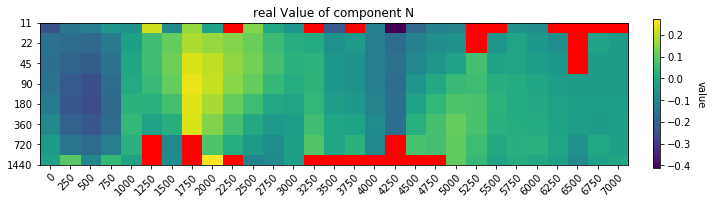

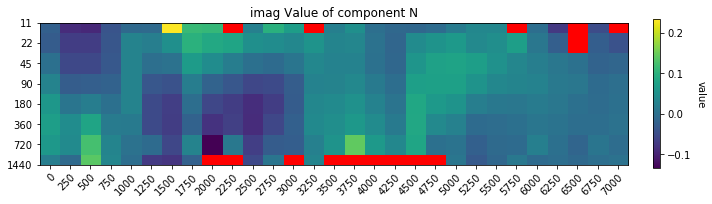

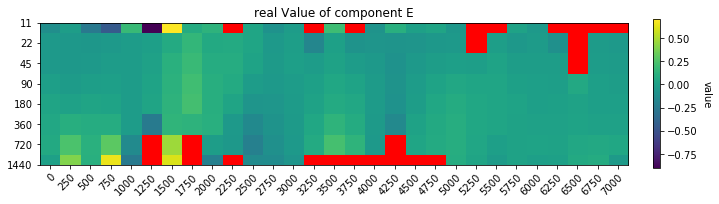

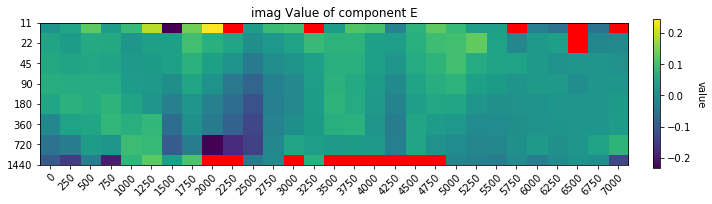

In [10]:
plot_data(data_line_5000,direction='N',part='real')
plot_data(data_line_5000,direction='N',part='imag')
plot_data(data_line_5000,direction='E',part='real')
plot_data(data_line_5000,direction='E',part='imag')

Oops, looks like there are some ```NAN``` fields which show up as red. Strangely, there are specific frequencies which are ```NAN``` in the real component, but exist in the imaginary component (and vice versa). I'll have to make non-```NAN``` values ```NAN``` if the corresponding component is ```NAN```.

In [11]:
"""
HELPER CELL

for assigning NAN values to the appropriate cell.

"""
def assign_NAN_values(df,direction='N',part='real'):
    frequencies = ['0011','0022','0045','0090','0180','0360','0720','1440']
    for freq in frequencies:
        for direction in ['N','E']:
            real_key = 'r'+direction+'_'+freq
            imag_key = 'i'+direction+'_'+freq
            df.loc[pd.isna(df[real_key]) | pd.isna(df[imag_key]), real_key] = np.nan
            df.loc[pd.isna(df[real_key]) | pd.isna(df[imag_key]), imag_key] = np.nan
                    
    return df

In [12]:
data_line_5000=assign_NAN_values(data_line_5000)

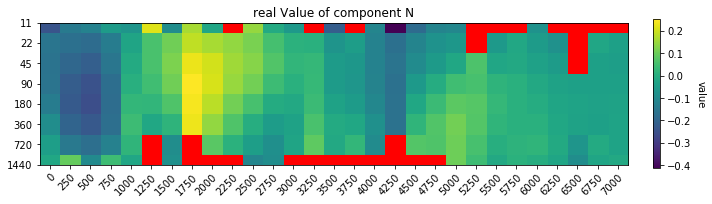

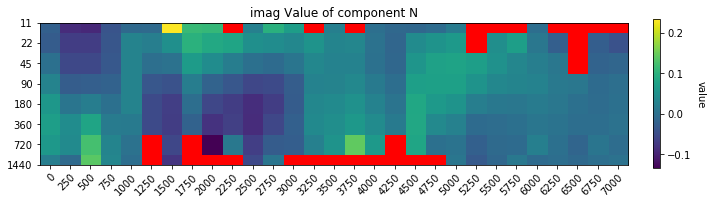

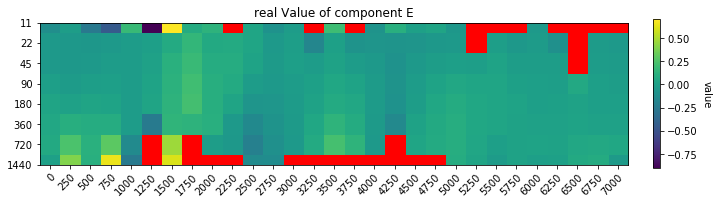

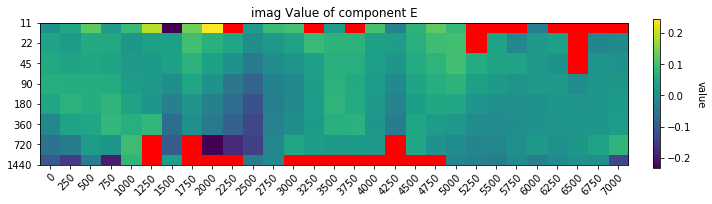

In [13]:
plot_data(data_line_5000,direction='N',part='real')
plot_data(data_line_5000,direction='N',part='imag')
plot_data(data_line_5000,direction='E',part='real')
plot_data(data_line_5000,direction='E',part='imag')

Ahh much better. At least the data gaps make sense now. 

We now have a choice to make. I can either:

* Ensure my inversion scheme can handle ```nan``` values.

* Drop stations with ```nan``` values.

* Restrict my frequency space to only contain non ```nan``` numbers.

* Interpolate values within reason.

There are drawbacks to each approach. Ensuring your inversion scheme can handle NaN's requires an intimate understanding of the program. My intended approach uses Occam2D, which does not handle nan values well. Dropping all stations with NaN values leaves us with a really sparse dataset. Restricting frequency space to non nan values means we now can only invert 3 of 8 frequencies. Interpolating values is like creating 'fake' data and will bias the inversion results.

How about a compromise?

First, I'll drop stations 1250, 1750, 4250, 5250, and 6500. These stations have the most nan values, and based on discussions with the team that acquired this data, nan values mean high uncertainty.

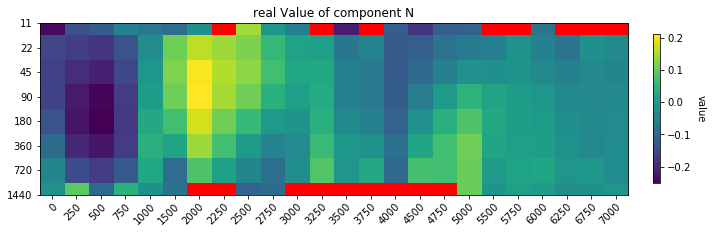

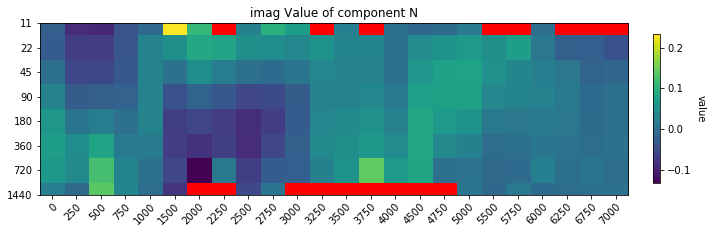

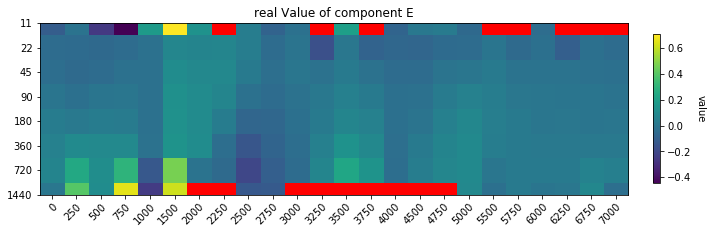

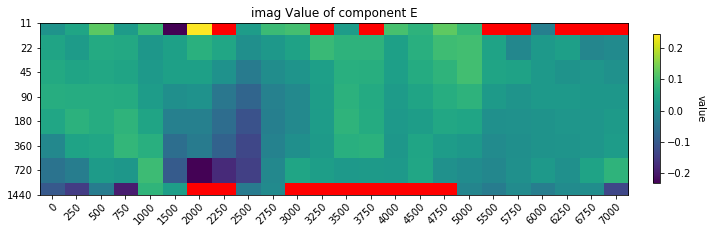

In [14]:
bad_stations = [1250,1750,4250,5250,6500]
new_data  = data_line_5000[~data_line_5000.Station.isin(bad_stations)]
new_data  = new_data.reset_index()
plot_data(new_data,direction='N',part='real')
plot_data(new_data,direction='N',part='imag')
plot_data(new_data,direction='E',part='real')
plot_data(new_data,direction='E',part='imag')

We still have NaN values on some of the channels. One approach to deal with this is to locally interpolate from the nearest value on each station. We could do this here OR we could do this when we convert to MtPy. I prefer the second option as it will allow us to use pandas ```fillna``` methods.

# Step 2. Prepare Data for MtPy

Every row in this pandas dataframe represents spectral Tipper data collected from a station. Before we can do any inversion, it's prudent to convert these to xml files on disk. While this isn't necessary, it will allow us to separate data cleaning from data analysis.

MtPy uses an object called ```MT``` contained in ```mtpy.core.mt```. An easy way to do the conversion is to use a function to assign every row's ```MT``` Object into an ```mt_obj``` column.

Documentation for ```MtPy's``` ```MT```object is lacking, but from reading the git repository I can tell the following items should be incorporated into our object:

* **Metadata**: Stuff like lat, lon, elevation, station. These are simple float/string attributes. Note that we can either provide MtPy with lat,lon or easting-northing information. I prefer using lat-lons in WGS84 format. It's a universal format used by most WMS, google maps, google earth, navigation software, and smartphone GPS apps. While it might be hard to convert lat-lon into meaningful distance measurements in the field, with the availability of packages like ```pyproj```, I find sending UTM coordinates are at best redundant and at worst, add unneeded complexity to data processing.
* **Tipper Data**: This is a bit more complex. It requires an array of frequencies, complex numbers, and needs to be shaped appropriatey. There is an option for incorporating error into the Tipper array, but for now we'll just set those to zero. **THIS IS WHERE THE FILL_NA COMES IN**. I'll use a fillna operation that relies on a succinct stackoverflow solution using a scipy image processing routine.

For ease of understanding, I'll make these separate functions which are then called by ```parse_row_into_mt_obj```.

In [15]:
"""
HELPER CELL

for parsing pandas dataframe row data into an MT object

"""

def fill(data, invalid=None):
    """
    FROM STACKOVERFLOW: 
    https://stackoverflow.com/questions/3662361/fill-in-missing-values-with-nearest-neighbour-in-python-numpy-masked-arrays
    Replace the value of invalid 'data' cells (indicated by 'invalid') 
    by the value of the nearest valid data cell

    Input:
        data:    numpy array of any dimension
        invalid: a binary array of same shape as 'data'. True cells set where data
                 value should be replaced.
                 If None (default), use: invalid  = np.isnan(data)

    Output: 
        Return a filled array. 
    """

    if invalid is None: invalid = np.isnan(data)

    ind = nd.distance_transform_edt(invalid, return_distances=False, return_indices=True)
    return data[tuple(ind)]

def create_simple_metadata(row):
    """
    extracts metadata from the pandas dataframe row, specifically:
    site (lat, lon, elevation, station, line)
    acquisition (azimuth, recording time)
    """
    lat     = row['Lat']
    lon     = row['Long']
    elev    = row['ALT']
    station = row['Station']
    
    return lat, lon, elev, station

def generate_tipper_arrays(row):
    """
    function to populate numpy arrays from pandas dataframe
    """
    frequencies = np.asarray([11, 22, 45, 90, 180, 360, 720, 1440])
    t_n=[]
    t_e=[]
    for freq in frequencies:
        real_east_key = f"rE_{freq:04}"
        imag_east_key = f"iE_{freq:04}"
        real_north_key= f"rN_{freq:04}"
        imag_north_key= f"iN_{freq:04}"
        t_e.append( row[real_east_key]+row[imag_east_key]*1j)
        t_n.append( row[real_north_key]+row[imag_north_key]*1j)
        
    t_n = fill(np.asarray(t_n,dtype=np.complex64))
    t_e = fill(np.asarray(t_e,dtype=np.complex64))
    return frequencies, t_n, t_e

def create_tipper(row):
    """
    creates an MtPy Tipper array from source numpy arrays and relevant metadata
    
    ############################# BIG WARNING #################################
    Notice Ive done something funny with the error array. This is purely for MtPy compatibility.
    To incorporate error please assign other values.
    """
    frequencies, t_n, t_e = generate_tipper_arrays(row)
    
    array            = np.ones((len(frequencies),1,2),dtype=np.complex64)
    tipper_err_array = np.ones((len(frequencies),1,2)) #<- change this to include error
    array[:,0,0]=t_n
    array[:,0,1]=t_e
    
    tipper = Tipper(tipper_array=array, tipper_err_array=tipper_err_array,
                    freq=frequencies)
    return tipper

def create_dummy_impedanc_tensor():
    """
    creates an MtPy Impedance Tensor object from dummy data
    
    ############################# BIG WARNING #################################
    Both the values and the error are made up here because the data is only made up of tipper data.
    This is done to maintain compatibility with MtPY
    """
    frequencies = np.asarray([11, 22, 45, 90, 180, 360, 720, 1440])
    z_array     = np.ones((len(frequencies),2,2),dtype=np.complex64)
    impedance_tensor = Z(z_array=z_array, z_err_array=z_array, freq=frequencies)
    return impedance_tensor

def parse_row_into_mt_obj(row):
    lat, lon, elev, station = create_simple_metadata(row)
    tipper   = create_tipper(row)
    impedance_tensor  = create_dummy_impedanc_tensor()
    mt_obj   = MT(station=station,lat=lat,lon=lon,elev=elev,Tipper=tipper,Z=impedance_tensor)
    return mt_obj

In [16]:
new_data['mt_obj']=new_data.apply(parse_row_into_mt_obj, axis=1)
new_data

/home/kevin/anaconda3/envs/mtpy_inv/lib/python3.6/site-packages/mtpy/core/z.py:125: ComplexWarning: Casting complex values to real discards the imaginary part
  self._resistivity[idx_f, ii, jj] * r_err


,index,Line,Station,Lat,Long,E_WGS84_Z7,N_WGS84_Z7,ALT,Az,Dur,...,iN_1440,SNI_0011,SNI_0022,SNI_0045,SNI_0090,SNI_0180,SNI_0360,SNI_0720,SNI_1440,mt_obj
0,182,5000,0,61.332953,-139.193146,596692.0,6801212.0,1015.0,294.3,144,...,0.023,38.6,160.2,385.1,603.8,484.1,455.3,704.7,477.2,<mtpy.core.mt.MT object at 0x7fdc4b9f4198>
1,184,5000,250,61.334589,-139.189912,596860.0,6801399.0,977.8,151.3,188,...,-0.007,67.6,207.4,491.3,742.5,544.4,155.9,165.1,145.6,<mtpy.core.mt.MT object at 0x7fdc4b9fc160>
2,185,5000,500,61.336235,-139.186733,597025.0,6801587.0,1002.1,40.4,147,...,0.139,41.0,150.2,324.8,585.7,542.6,482.1,418.0,128.0,<mtpy.core.mt.MT object at 0x7fdc4b9fccf8>
3,186,5000,750,61.338026,-139.183675,597183.0,6801791.0,990.7,40.7,263,...,0.035,50.5,206.8,510.2,736.4,538.5,342.3,178.1,16.6,<mtpy.core.mt.MT object at 0x7fdc4b9fc5f8>
4,187,5000,1000,61.339457,-139.181200,597311.0,6801954.0,966.2,265.1,273,...,-0.001,34.6,179.6,521.7,830.8,708.4,253.2,147.5,45.8,<mtpy.core.mt.MT object at 0x7fdc4b9b7438>
5,190,5000,1500,61.342927,-139.174137,597678.0,6802351.0,909.5,194.6,274,...,-0.077,31.1,190.8,615.9,1029.6,828.2,194.7,48.5,9.2,<mtpy.core.mt.MT object at 0x7fdc4b9b7b00>
6,192,5000,2000,61.346186,-139.168076,597992.0,6802723.0,891.1,285.6,215,...,NaN,12.8,139.5,376.9,592.0,387.6,83.0,25.6,0.0,<mtpy.core.mt.MT object at 0x7fdc4b952048>
7,194,5000,2250,61.347940,-139.164963,598153.0,6802923.0,916.7,236.7,258,...,NaN,24.8,112.3,413.1,684.7,469.5,292.3,221.9,76.2,<mtpy.core.mt.MT object at 0x7fdc4b952668>
8,195,5000,2500,61.349670,-139.162075,598302.0,6803120.0,935.2,130.2,123,...,-0.053,42.5,147.8,363.0,486.8,418.0,418.4,218.8,20.1,<mtpy.core.mt.MT object at 0x7fdc4b952c18>
9,196,5000,2750,61.351332,-139.158817,598471.0,6803310.0,989.7,336.6,180,...,0.008,33.0,145.0,406.5,771.5,1317.7,1987.1,1204.5,178.7,<mtpy.core.mt.MT object at 0x7fdc4b956208>


One of the under appreciated aspects of pandas is that the live memory version of dataframes can store and index arbitrarily defined objects. I would not reccomend saving this again as a .csv to file, but it allows us to efficiently query, plot, and examine objects. 

Now that we seem to have created indexed ```MTPy``` objects, we need to verify that the attributes contained in the live objects match those from the dataframe. Trust, but verify. Another benefit of this approach is that I now have  a separate code section specifically dedicated to testin. If errors in the data cleaning are discovered at a later date, I can add additional checks here to prevent the same error from ocurring again.

In [17]:
"""
HELPER CELL

for assuring the created MT object is equivalent to its dataframe source data

"""
def metadata_assertions(row):
    mt_obj = row['mt_obj']
    lat     = row['Lat']
    lon     = row['Long']
    elev    = row['ALT']
    station = row['Station']
    
    assert mt_obj.elev ==elev,"elevations don't match"
    assert mt_obj.station==station,"stations don't match"
    assert mt_obj.lon==lon,"longitudes don't match"
    assert mt_obj.lat==lat,"latitudes don't match"

def tipper_assertions(row):
    mt_obj = row['mt_obj']
    frequencies, t_n, t_e=generate_tipper_arrays(row)
    source_tipper = mt_obj.Tipper
    target_tipper = create_tipper(row)
    np.testing.assert_array_equal(source_tipper.tipper,target_tipper.tipper,'tipper arrays not equal')
    
def verify_row_corresponds_to_mt_obj(row):
    tipper_assertions(row)
    metadata_assertions(row)

In [18]:
for index, row in new_data.iterrows():
    verify_row_corresponds_to_mt_obj(row)
print('data is verified')

data is verified


MtPy supports three main file types often used in MT: .xml, .edi, and .Jfile. While the .edi format is probably the most popular at the moment, a wide variety of perspectives on where and how to store metadata within the format has motivated the community to explore other ways of storing data. My favorite candidate file format is the netcdf4-5 datatype widely used by the meteorological community to describe multidimensional datasets. The .xml format is also an attractive candidate due to its self-describing structure. For now, I'll stick to saving the data in an intermediate .edi format.

I'll add some machinery to create and delete any intermediate files in the .edi directory. This is a best practice to ensure that any modification to data preprocessing is both reproducible and robust.

The last thing we need to do here is save the ```MT_obj```'s to file and ensure their integrity by loading them up and verifying the data much like we did before. 

In [19]:
directory='edi_files'
# create temporary data directory
if not os.path.exists(directory):
    os.makedirs(directory)
    
# clear existing edi files in directory
files = glob.glob('edi_files/*.edi')
for f in files:
    os.remove(f)

In [20]:
# save every station as an .edi file into directory  
for index, row in new_data.iterrows():
    row['mt_obj'].write_mt_file(save_dir=directory, fn_basename=str(row['Station']), file_type='edi',
                      longitude_format='LON',latlon_format='dd')

/home/kevin/anaconda3/envs/mtpy_inv/lib/python3.6/site-packages/mtpy/core/z.py:125: ComplexWarning: Casting complex values to real discards the imaginary part
  self._resistivity[idx_f, ii, jj] * r_err


In [21]:
"""
HELPER CELL

loads .edi files into a dataframe, then compares it to the previously loaded file

"""

def check_one_edi_per_station():
    files = glob.glob('edi_files/*.edi')
    assert len(files)==24,"differing number of .edi files and stations"
    
def convert_tipper_to_csv_columns(mt_obj):
    new_row      = {}
    frequencies  = mt_obj.Tipper.freq
    tipper_array = mt_obj.Tipper.tipper
    t_n=[]
    t_e=[]
    for index,freq in enumerate(frequencies):
        int_freq = int(freq)
        real_east_key = f"rE_{int_freq:04}"
        imag_east_key = f"iE_{int_freq:04}"
        real_north_key= f"rN_{int_freq:04}"
        imag_north_key= f"iN_{int_freq:04}"
        
        new_row[real_east_key]  = tipper_array[index,0,1].real
        new_row[imag_east_key]  = tipper_array[index,0,1].imag
        new_row[real_north_key] = tipper_array[index,0,0].real
        new_row[imag_north_key] = tipper_array[index,0,0].imag
    return new_row
    
def extract_edi_to_dataframe_row(row):
    mt_obj  = MT(row['filepath'])
    new_row = convert_tipper_to_csv_columns(mt_obj)
    new_row['Lat']    = mt_obj.lat
    new_row['Long']   = mt_obj.lon
    new_row['ALT']    = mt_obj.elev
    new_row['Station']= int(float(mt_obj.station))
    new_row['mt_obj'] = mt_obj
    return new_row
    
    
def convert_edi_files_into_dataframe():
    files = glob.glob('edi_files/*.edi')
    df    = pd.DataFrame(files,columns=['filepath'])
    new_rows = []
    for index,row in df.iterrows():
        new_rows.append(extract_edi_to_dataframe_row(row))
    df    = pd.DataFrame(new_rows)
    df  = df.sort_values(by=['Station'],ascending = [True])
    return df

def check_both_dataframes_are_equivalent(source_df,target_df):
    columns = ['Station', 'Lat', 'Long', 'ALT','rE_0011', 'rE_0022', 'rE_0045', 'rE_0090',
       'rE_0180', 'rE_0360', 'rE_0720', 'rE_1440', 'rN_0011', 'rN_0022',
       'rN_0045', 'rN_0090', 'rN_0180', 'rN_0360', 'rN_0720', 'rN_1440',
       'iE_0011', 'iE_0022', 'iE_0045', 'iE_0090', 'iE_0180', 'iE_0360',
       'iE_0720', 'iE_1440', 'iN_0011', 'iN_0022', 'iN_0045', 'iN_0090',
       'iN_0180', 'iN_0360', 'iN_0720', 'iN_1440']
    for col in columns:
        target_series = target_df[col]
        source_series = source_df[col]
        try:
            np.testing.assert_array_equal(target_series.values,
                                          source_series.values,'{} columns not equal'.format(col))
        except:
            print('******************************')
            print(col)
            print('******************************')
            for s,t in zip(target_series.values,source_series.values):
                print('source:{} target:{} diff:{}'.format(s,t,s-t))
    

In [22]:
check_one_edi_per_station()
df = convert_edi_files_into_dataframe()
check_both_dataframes_are_equivalent(df,new_data)

******************************
Lat
******************************
source:61.33295316 target:61.332953 diff:1.5999999902760464e-07
source:61.33458935 target:61.334589 diff:3.500000005374204e-07
source:61.33623517 target:61.336235 diff:1.6999999985500835e-07
source:61.33802624 target:61.338026 diff:2.3999999854140697e-07
source:61.33945685 target:61.339457 diff:-1.500000053056283e-07
source:61.34292716 target:61.342927 diff:1.5999999902760464e-07
source:61.34618612 target:61.346186 diff:1.199999957179898e-07
source:61.34794011 target:61.34794 diff:1.1000000199601345e-07
source:61.34967013 target:61.34967 diff:1.2999999654539351e-07
source:61.35133223 target:61.351332 diff:2.2999999771400326e-07
source:61.35316032 target:61.35316 diff:3.199999980552093e-07
source:61.35469588 target:61.354696 diff:-1.199999957179898e-07
source:61.35643206 target:61.356432 diff:6.000000496442226e-08
source:61.35801488 target:61.358015 diff:-1.2000000282341716e-07
source:61.35982270000001 target:61.359823 di

The utility of doing these kinds of checks is immediately demonstrated. Every column value test failed except for station. However, the tipper data appears to be identical within floating point precision ($\approx$1e-16). Lat-Lon data appears to have dropped off a decimal place ($\approx$1e-7), perhaps as part of MtPy's internal handling of decimal degrees. Still, the data are close enough to be trusted.


**WAIT**. Remember when I said we needed to fill those nan values? lets check really quick to see if that happened.

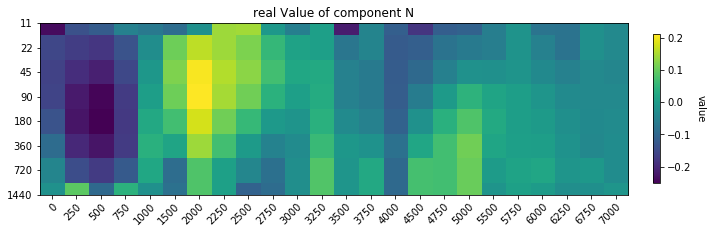

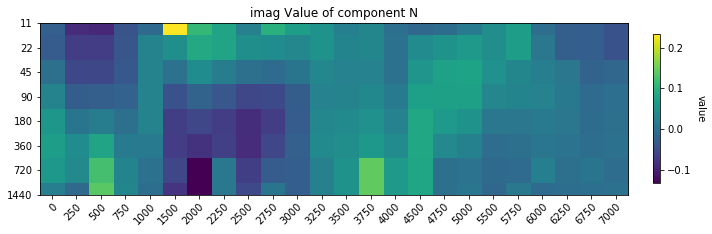

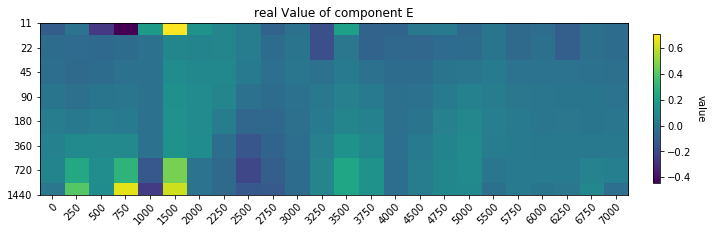

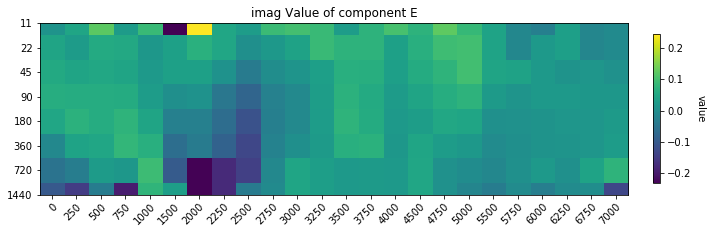

In [23]:
new_data  = new_data.reset_index()
plot_data(df,direction='N',part='real')
plot_data(df,direction='N',part='imag')
plot_data(df,direction='E',part='real')
plot_data(df,direction='E',part='imag')

Perfect! As long as we keep in mind the surface and deepest layers may be biased towards a smooth halfspace.

Thats it for this notebook. In the next notebook I'll examine the data directly and see what can be interpreted working towards a 2d inversion.